# Piyush_Chouhan_Clustering.ipynb

# Task 3: Customer Segmentation / Clustering

The goal of this notebook is to:
1. Perform customer segmentation using clustering techniques.
2. Use both profile information (from Customers.csv) and transaction information (from Transactions.csv).
3. Evaluate clustering performance using metrics like the DB Index.
4. Visualize clusters for insights.

---

In [9]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better visuals
sns.set(style='whitegrid')

## Step 1: Load the Data
We will load the datasets: `Customers.csv` and `Transactions.csv`.

In [10]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Display the first few rows
print("Customers Data:")
print(customers.head())

print("\nTransactions Data:")
print(transactions.head())

Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


## Step 2: Preprocess the Data

1. Merge the datasets to include profile and transaction data for each customer.
2. Aggregate transaction data by customer to get a summary of spending patterns.

In [11]:
# Aggregate transaction data by customer
transactions_summary = transactions.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).reset_index()

# Merge with customer data
customer_data = pd.merge(customers, transactions_summary, on='CustomerID', how='inner')

# Display the merged data
print("Merged Customer Data:")
print(customer_data.head())

Merged Customer Data:
  CustomerID        CustomerName         Region  SignupDate  Quantity  \
0      C0001    Lawrence Carroll  South America  2022-07-10        12   
1      C0002      Elizabeth Lutz           Asia  2022-02-13        10   
2      C0003      Michael Rivera  South America  2024-03-07        14   
3      C0004  Kathleen Rodriguez  South America  2022-10-09        23   
4      C0005         Laura Weber           Asia  2022-08-15         7   

   TotalValue  
0     3354.52  
1     1862.74  
2     2725.38  
3     5354.88  
4     2034.24  


## Step 3: Prepare Data for Clustering

We will:

1. Drop irrelevant columns (e.g., names or IDs).
2. Normalize numerical data to ensure fair clustering.

In [13]:
# Drop irrelevant columns
data_for_clustering = customer_data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)

# Step 2: Handle categorical variables (e.g., one-hot encoding)
categorical_columns = data_for_clustering.select_dtypes(include=['object']).columns
data_for_clustering = pd.get_dummies(data_for_clustering, columns=categorical_columns)

# Normalize the data
scaler = StandardScaler()
numerical_columns = data_for_clustering.select_dtypes(include=['float64', 'int64']).columns
normalized_data = scaler.fit_transform(data_for_clustering[numerical_columns])

# Convert back to a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=numerical_columns)

# Display normalized data
print("Normalized Data for Clustering:")
print(normalized_df.head())

Normalized Data for Clustering:
   Quantity  TotalValue
0 -0.122033   -0.061701
1 -0.448000   -0.877744
2  0.203934   -0.405857
3  1.670787    1.032547
4 -0.936951   -0.783929


## Step 4: Perform Clustering

1. Use the KMeans algorithm with a range of clusters (2 to 10).
2. Calculate the Davies-Bouldin Index (DB Index) for each clustering result.

In [14]:
# Initialize variables to store results
db_index_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_df)
    
    # Get cluster labels
    labels = kmeans.labels_
    
    # Calculate the DB Index
    db_index = davies_bouldin_score(normalized_df, labels)
    db_index_scores.append(db_index)
    
    print(f"Clusters: {k}, DB Index: {db_index:.4f}")

Clusters: 2, DB Index: 0.6267
Clusters: 3, DB Index: 0.7087
Clusters: 4, DB Index: 0.7213
Clusters: 5, DB Index: 0.7767
Clusters: 6, DB Index: 0.8225
Clusters: 7, DB Index: 0.8784
Clusters: 8, DB Index: 0.9432
Clusters: 9, DB Index: 0.8807
Clusters: 10, DB Index: 0.8138


## Step 5: Visualize DB Index

We will plot the DB Index values to determine the optimal number of clusters.

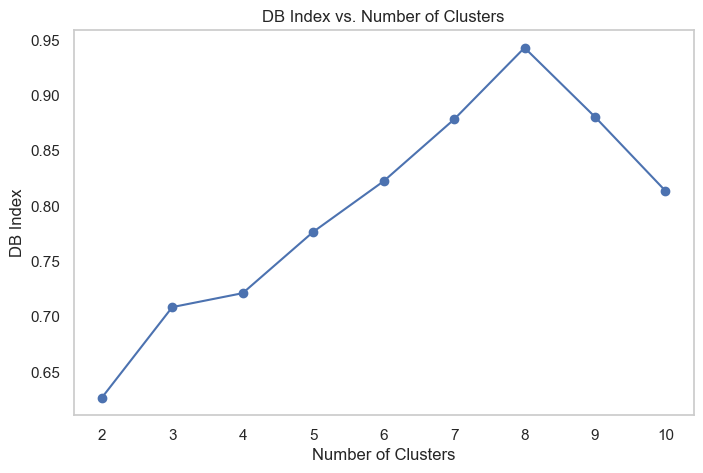

In [15]:
# Plot DB Index values
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_index_scores, marker='o', linestyle='-', color='b')
plt.title('DB Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.xticks(cluster_range)
plt.grid()
plt.show()

## Step 6: Select Optimal Clusters and Visualize

1. Select the number of clusters with the lowest DB Index.
2. Visualize the clusters using scatter plots.

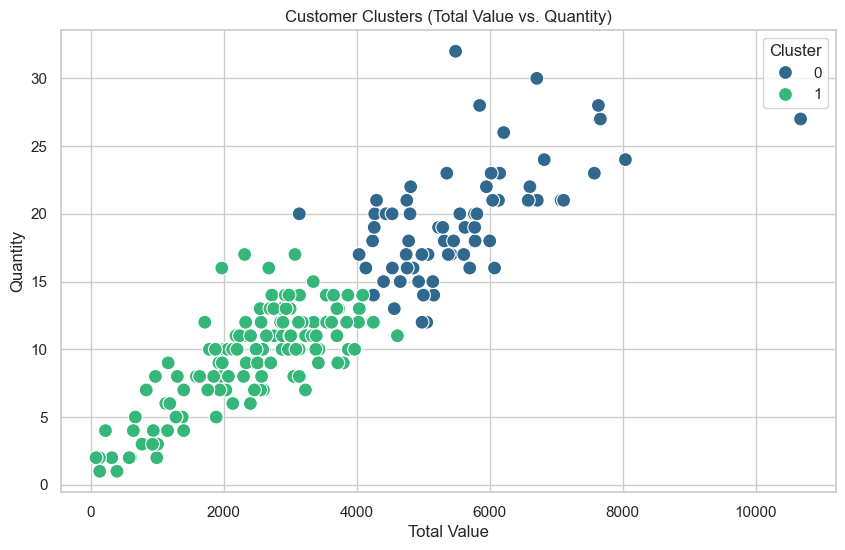

In [16]:
# Optimal number of clusters (manually determined from the plot)
optimal_clusters = cluster_range[np.argmin(db_index_scores)]

# Perform KMeans clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(normalized_df)

# Add cluster labels to the original dataset
customer_data['Cluster'] = kmeans.labels_

# Visualize clusters with TotalValue vs. Quantity
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='TotalValue', y='Quantity', hue='Cluster',
    data=customer_data, palette='viridis', s=100
)
plt.title('Customer Clusters (Total Value vs. Quantity)')
plt.xlabel('Total Value')
plt.ylabel('Quantity')
plt.legend(title='Cluster')
plt.show()

## Step 7: Save Results

We will save the clustered data into a CSV file for further analysis.

In [17]:
# Save the clustered data to a CSV file
customer_data.to_csv('Customer_Segments.csv', index=False)
print("Clustered data saved to Customer_Segments.csv")

Clustered data saved to Customer_Segments.csv


## Step 8: Report Metrics and Insights

In [18]:
# Report final metrics
final_db_index = min(db_index_scores)
print(f"Final Number of Clusters: {optimal_clusters}")
print(f"Final DB Index: {final_db_index:.4f}")

# Display cluster counts
print("\nCluster Distribution:")
print(customer_data['Cluster'].value_counts())

Final Number of Clusters: 2
Final DB Index: 0.6267

Cluster Distribution:
Cluster
1    132
0     67
Name: count, dtype: int64
